In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
from typing import *


class BanditEnv:
    def __init__(self, probabilities: list[float], rewards: list[int]) -> None:
        self.probabilities = probabilities
        self.rewards = rewards

    def step(self, action: int) -> int:
        if torch.rand(1).item() < self.probabilities[action]:
            return self.rewards[action]
        return 0

In [3]:
probabilities = [0.1, 0.15, 0.3]
rewards = [4, 3, 1]
bandit_env = BanditEnv(probabilities, rewards)

# Случайная стратегия

Определим стратегию, которая опр. рычаг случайным образом

In [4]:
def random_policy() -> int:
    return torch.multinomial(torch.ones(len(rewards)), 1).item()

In [5]:
n_episodes = 100000
n_action = len(rewards)

action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

for episode in range(n_episodes):
    action = random_policy()
    reward = bandit_env.step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

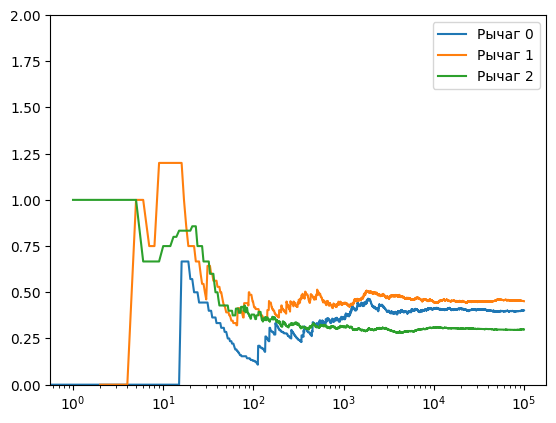

0.38391


In [6]:
for action in range(n_action):
    plt.plot(action_avg_reward[action], )

plt.legend([f"Рычаг {i}" for i in range(n_action)])
plt.ylim(bottom=0, top=2)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

# Eps-жадная стратегия

Каждое действие выб с вероятностью $eps/|A|$, где $|A|$ - количество возм. действий.

Предпочтение отдаётся действию с макс. ценностью, а вероятность его выбора увел. на 1-eps, вероятность равна 1-eps+eps/|A|

In [7]:
def eps_greedy_policy(n_action: int, eps: float, Q: Any) -> float:
    probabilities = torch.ones(n_action) * eps / n_action
    best_action = torch.argmax(Q).item()
    probabilities[best_action] += 1 - eps
    return torch.multinomial(torch.ones(len(probabilities)), 1).item()

In [8]:
n_episodes = 100000
n_action = len(rewards)

action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

eps: Final[float] = 0.2
Q = torch.zeros(n_action)

for episode in range(n_episodes):
    action = eps_greedy_policy(n_action, eps, Q)
    reward = bandit_env.step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

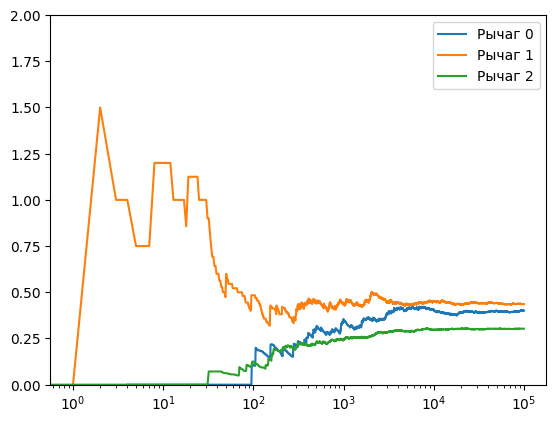

0.37978


In [9]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend([f"Рычаг {i}" for i in range(n_action)])
plt.ylim(bottom=0, top=2)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

# Softmax-исследование

P(a) = (exp(Q(a)/r))/sum()sdkvhmsgdvfsvdkfhj

In [10]:
def softmax_policy(tau, Q):
    probabilities = torch.exp(Q / tau)
    probabilities = probabilities / torch.sum(probabilities)
    action = torch.multinomial(probabilities, 1).item()
    return action

In [11]:
n_episodes = 100000
n_action = len(rewards)

action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

tau: Final[float] = 0.2
Q = torch.zeros(n_action)

for episode in range(n_episodes):
    action = softmax_policy(tau, Q)
    reward = bandit_env.step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

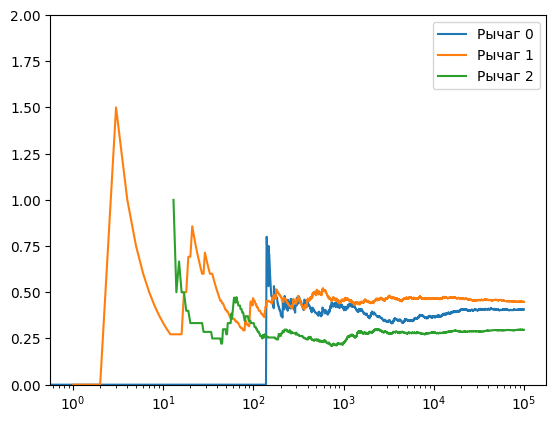

0.40411


In [12]:
for action in range(n_action):
    plt.plot(action_avg_reward[action], )

plt.legend([f"Рычаг {i}" for i in range(n_action)])
plt.ylim(bottom=0, top=2)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

# Точечная и интервальная оценка параметров случайной величины

Пусть:
$x$ - случайная величина
$\theta$ - параметр этой СВ

Имеем $k$ реализаций СВ:

$x^1_1, x^1_2,... - \theta^{1}$  
$x^2_1, x^2_2,... - \theta^{2}$  
...  
$x^n_1, x^n_2,... - \theta^{n}$


Точечной оценкой называется число, которое используют для оценки параметра СВ.  
Доверительный интервал - интервал, который с заданной вероятностью накрывает оцениваемый параметр СВ.  

При работе с доверительным интервалом используют термины:  
Уровень значимости $\alpha$ -  
Уровень доверия $\beta = 1 - \alpha$  

__Построение доверительного интервала__

$(\bar{\theta}-\Delta, \bar{\theta}+\Delta)$, где $\Delta$ - точность интервальной оценки

$\Delta=\sigma / \sqrt{n} \cdot z_\alpha$, где $z_\alpha$ - квантиль некоторого распределения уровня $1-\alpha/2$

$(\bar{\theta}-\sigma/\sqrt{n}\cdot z_\alpha, \bar{\theta}+\sigma/\sqrt{n}\cdot z_\alpha)$

## Верхняя доверительная граница
$UCB(a)=Q(a)+\sqrt{2log(t)}/sqrt{N(a)}$,  
где $t$ - количество эпизодов, $N(a)$ - сколькл раз в t эпизодах выбирался рычаг a.

In [6]:
def upper_confidence_bound(Q: torch.Tensor, action_count: int, t: int):
    ucb = torch.sqrt(2 * torch.log(torch.tensor(t)) / action_count) + Q
    action = torch.argmax(ucb)
    return action

In [7]:
n_episodes = 100000
n_action = len(rewards)

action_count = torch.zeros(n_action)
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

tau: Final[float] = 0.2
Q = torch.zeros(n_action)

for episode in range(n_episodes):
    action = upper_confidence_bound(Q, action_count, n_episodes)
    reward = bandit_env.step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

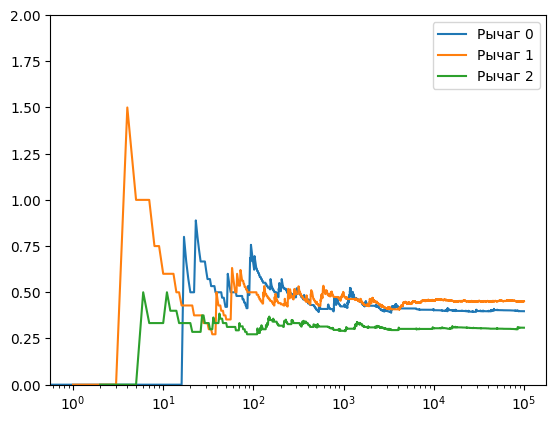

0.44741


In [8]:
for action in range(n_action):
    plt.plot(action_avg_reward[action], )

plt.legend([f"Рычаг {i}" for i in range(n_action)])
plt.ylim(bottom=0, top=2)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

# Решение задачи о рекламе

Задача: оптимизировать показ объявлений на сайте

Есть три способа подачи рекламы.

Для каждого посетителя выбрать объявление, которое максимизирует кликабельность на протяжении длительного времени.

In [9]:
probabilities = [0.01, 0.015, 0.03]
rewards = [1, 1, 1]
bandit_env = BanditEnv(probabilities, rewards)

In [10]:
n_episodes = 10000
n_action = len(rewards)

action_count = torch.zeros(n_action)
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

tau: Final[float] = 0.2
Q = torch.zeros(n_action)

for episode in range(n_episodes):
    action = upper_confidence_bound(Q, action_count, n_episodes)
    reward = bandit_env.step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

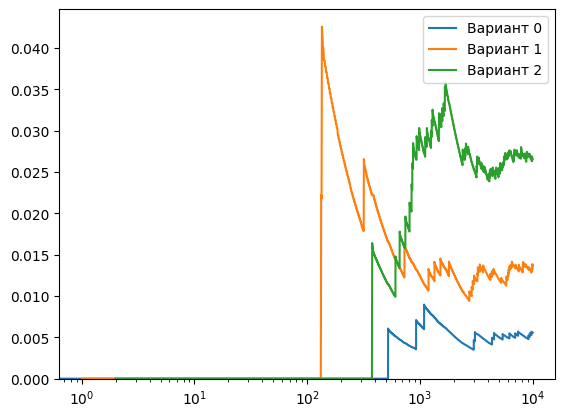

0.0173


In [11]:
for action in range(n_action):
    plt.plot(action_avg_reward[action], )

plt.legend([f"Вариант {i}" for i in range(n_action)])
plt.ylim(bottom=0)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

# Решение задачи с помощью нескольких контекстуальных бандитов
Контекстуальные бандиты - обобщение путем добавления состояния

In [12]:
bandit_probabilities = [
    [0.01, 0.015, 0.01],
    [0.025, 0.01, 0.015]
]
bandit_rewards = [
    [1, 1, 1],
    [1, 1, 1]
]
n_machines = len(bandit_probabilities)

envs = [BanditEnv(probabilities, rewards) for probabilities, rewards in zip(bandit_probabilities, bandit_rewards)]

In [13]:
import random
import numpy as np

n_episodes = 100000
n_action = len(rewards)

action_count = torch.zeros(n_action)
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[float | None]] = [[] for _ in range(n_action)]

action_machines = np.random.randint(0, 2, size=n_episodes)
print(f"0: {sum(action_machines == 0)}, 1: {sum(action_machines == 1)}")

Q = torch.zeros(n_action)

for episode, machine in zip(range(n_episodes), action_machines):
    action = upper_confidence_bound(Q, action_count, n_episodes)
    reward = envs[machine].step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

0: 50173, 1: 49827


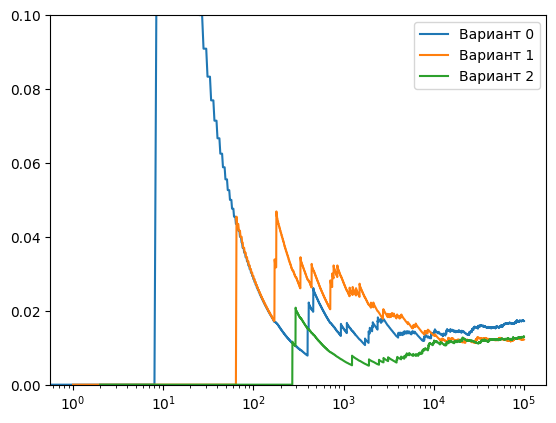

0.01456


In [14]:
for action in range(n_action):
    plt.plot(action_avg_reward[action], )

plt.legend([f"Вариант {i}" for i in range(n_action)])
plt.ylim(bottom=0, top=0.1)
plt.xscale("log")
plt.show()

print(sum(action_total_reward) / n_episodes)

In [15]:
machines_number: Final[int] = 2

action_statistics: list[dict[str, Any]] = [
    {
        "action_count": torch.zeros(n_action),
        "action_total_reward": [0 for _ in range(n_action)],
        "action_avg_reward": [[] for _ in range(n_action)],
        "Q": torch.zeros(n_action)
    }
    for _ in range(machines_number)
]

action_machines = np.random.randint(0, machines_number, size=n_episodes)
print(f"0: {sum(action_machines == 0)}, 1: {sum(action_machines == 1)}")

for episode, machine in zip(range(n_episodes), action_machines):
    current_machine_stats: dict[str, Any] = action_statistics[machine]
    Q: torch.Tensor = current_machine_stats.get("Q")
    action_count: torch.Tensor = current_machine_stats.get("action_count")
    action_total_reward: list[int] = current_machine_stats.get("action_total_reward")
    action_avg_reward: list[list[int]] = current_machine_stats.get("action_avg_reward")

    action = upper_confidence_bound(Q, action_count, n_episodes)
    reward = envs[machine].step(action)

    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for i in range(n_action):
        if action_count[i] != 0:
            action_avg_reward[i].append(action_total_reward[i] / action_count[i])
        else:
            action_avg_reward[i].append(None)

0: 50065, 1: 49935


0.01435


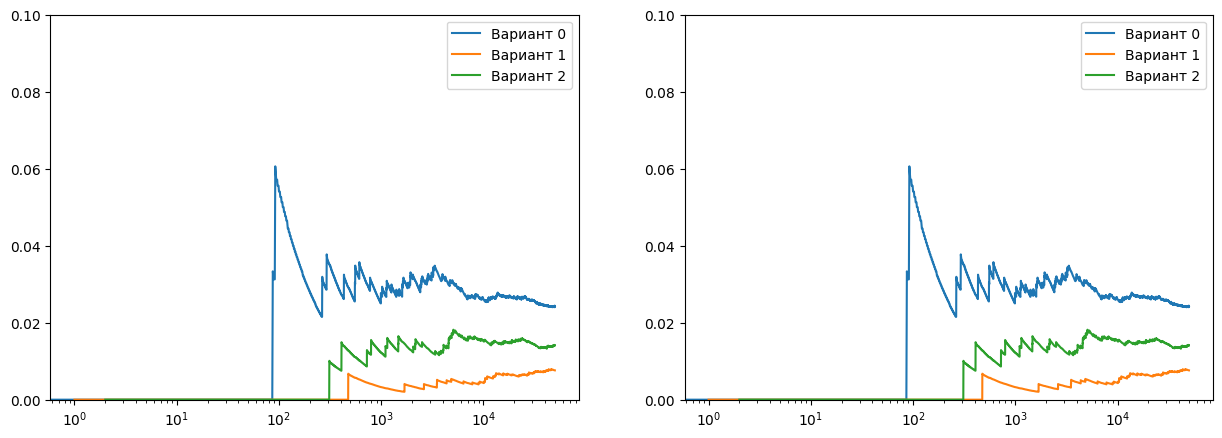

In [16]:
fig, _ = plt.subplots(1, 2, figsize=(15, 5))

for axis in fig.axes:
    for action in range(n_action):
        axis.plot(action_avg_reward[action])
    axis.legend([f"Вариант {i}" for i in range(n_action)])
    axis.set_ylim(bottom=0, top=0.1)
    axis.set_xscale("log")

print(sum([sum(reward) for reward in [action_statistics[i]["action_total_reward"] for i in range(machines_number)]]) / n_episodes)

In [17]:
bandit_probabilities = [
    [0.01, 0.015, 0.01],
    [0.025, 0.01, 0.015]
]
bandit_rewards = [
    [1, 1, 1],
    [1, 1, 1]
]
n_machines = len(bandit_probabilities)

action_count = torch.zeros(n_action)
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward: list[list[list[float | None]]] = [[[] for _ in range(n_action)] for _ in range(n_machines)]

envs = [BanditEnv(probabilities, rewards) for probabilities, rewards in zip(bandit_probabilities, bandit_rewards)]

Q_machines = torch.empty(n_machines, n_action)

In [ ]:
for episode in range(n_episodes):
    state = torch.randint(0, n_machines, (1,)).item()
    action = upper_confidence_bound(Q_machines[state], action_count[state], episode)
    reward = envs[state].step(action)
    action_count[state][action] += 1
    action_total_reward[state][action] += reward
    

    # не успел